In [1]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()

In [7]:
from FewShotCVRP.bo_pure import BayesianOptimizer
snap = BayesianOptimizer.load_snapshot("../outputs/bo-control-X-n641-k35.xml-2025-08-28-06h45m42s")

gp = snap.gp
X = snap.arrays["X_"]
y = snap.arrays["y_"]
print("Kernel:", gp.kernel_)
print("Best:", snap.result["x_obs_best"], snap.result["y_obs_best"])
mu, std = gp.predict(X[:3], return_std=True)
print("Posterior @ first 3 points:", mu, std)

Kernel: 0.714**2 * RBF(length_scale=[2.27e+04, 37.2, 8.99e+03, 236, 7.75e+05, 0.765, 7.73, 2.31, 8.41, 0.0136, 0.286, 1.24e+05, 1.75e+04, 0.014, 0.0757, 9.3, 0.0509, 2.03, 0.058, 0.0404, 1.09e+06, 1.43e+05, 0.308, 8.43e+03, 9.51, 22.4, 61, 0.43, 0.0437, 6.35, 916, 6.29e+03, 4.5e+03, 5.15, 0.448, 579, 1.19, 0.163, 38.5, 6.82e+03, 2.35e+03, 120, 191, 3.17e+05, 0.0603, 2.01e+05, 3.27e+04, 8.23e+06, 16.1, 2.84e+05, 1.33, 0.153, 1.33e+04, 0.454, 499, 0.0272, 517, 1.66e+05, 0.0224, 7.79e+04, 0.439, 1.45e+03, 1.03e+05, 1.29e+04, 0.157, 0.0103, 3.62e+04, 274, 0.0111, 9.18e+05, 1.66, 1.77e+06, 324, 1.18e+03, 995, 1.67e+06, 917, 9.23, 3.5, 0.259, 1.38e+04, 0.705, 1.92e+03, 8.4, 9.38e+03, 97.7, 109, 3.03, 1.62e+03, 6.04e+03, 0.0431, 1.06e+03, 4.42, 0.0382, 1.07, 148, 9.34e+06, 0.0361, 1.27e+03, 4.22e+03, 2.88e+06, 2.93e+05, 2.16e+05, 1.07e+05, 3.38e+06, 5.2e+03, 6.04, 2.91e+04, 9.32e+03, 4.1e+03, 199, 1.37e+05, 3.23e+06, 96.3, 9.32e+06, 1.1e+06, 2.77, 1.96e+03, 1.55e+04, 2.78e+03, 0.229, 4.86e+06

In [9]:
print(snap.result["y_rec_mean_global"])
print(snap.result["y_obs_best"])

251542.70153846155
212182.0


In [3]:
import FewShotCVRP.bo.bo_torch as bo_torch

bo_snap = bo_torch.BayesianOptimizer.load_snapshot("../outputs/2025-09-13-03h51m20s/per-instance-param-control/X-n101-k25/bo-final")

In [8]:
import numpy as np

np.array([1,2]).reshape(-1, 1)

array([[1],
       [2]])

In [ ]:
from importlib import reload
import FewShotCVRP.bo.bo_torch as bo_torch

reload(bo_torch)

bo_recovered = bo_torch.BayesianOptimizer(
    None,
    f_batch=None,
    bounds=bo_snap.arrays["bounds"],
    n_init=200,
    n_iter=90,
    sigma=600,
    kernel="rbf",
    kernel_isotropic=False,
    doe_method="sobol",
    n_restarts_acq_opt=100,
    suggestions_per_step=30,
    diversity_frac=0.1,
    random_state=2,
)
gp = bo_recovered._create_gp_model(
    bo_torch._as_t(
        bo_snap.arrays["X_"], dtype=bo_recovered.dtype, device=bo_recovered.device
    ),
    bo_torch._as_t(
        bo_snap.arrays["y_"].reshape(-1, 1), dtype=bo_recovered.dtype, device=bo_recovered.device
    ),
)
gp.load_state_dict(bo_snap.gp)


<All keys matched successfully>

In [16]:
bo_recovered.gp_ = gp


In [21]:
X = bo_torch._as_t(
    np.array(bo_snap.result["x_rec_mean_in_data"]).reshape(1, -1),
    dtype=bo_recovered.dtype,
    device=bo_recovered.device,
)
bo_recovered.posterior(X, return_std=True)

(array([29566.88101855]), array([597.53073565]))

### Simulation constants configuration

In [ ]:
import FewShotCVRP.ea as ea
import FewShotCVRP.examples.params_search.nn as nn

random_seed = 3
constants = nn.SimulationConstants(
    cvrp_instance_str="X-n641-k35.xml",
    ea_window_size=5,
    ea_generations_number=50,
    ea_lambda_=2 * 10**4,
    ea_mutation_operator=ea.mutate_shift_2opt_fast_fast,
    in_dim=10,
    hidden_dims=[15],
    theta_min=1.0,
    theta_max=100.0,
    activation=nn.nn.SiLU,
)

TypeError: SimulationConstants.__init__() got an unexpected keyword argument 'random_seed'

### Descent

In [34]:
cvrp = nn.get_cvrp_instance(constants.cvrp_instance_str)

res_descent = ea.descent(
    cvrp=cvrp,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    mutation=constants.ea_mutation_operator,
    seed=constants.random_seed,
)
print(res_descent["best_fitness"])

76542.0


### EA with fixed $\theta$ **schedule**

In [35]:
import numpy as np

cvrp = nn.get_cvrp_instance(constants.cvrp_instance_str)

res_theta_schedule = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=np.linspace(100.0, 1.0, constants.ea_generations_number), #[10.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

[init] fitness=339089.000000
[gen 1] theta=100 fitness=324959.000000 ↑ evals=20001/1000001
[gen 2] theta=98 fitness=315163.000000 ↑ evals=40001/1000001
[gen 3] theta=96 fitness=306630.000000 ↑ evals=60001/1000001
[gen 4] theta=93.9 fitness=302058.000000 ↑ evals=80001/1000001
[gen 5] theta=91.9 fitness=296381.000000 ↑ evals=100001/1000001
[gen 6] theta=89.9 fitness=293752.000000 ↑ evals=120001/1000001
[gen 7] theta=87.9 fitness=291186.000000 ↑ evals=140001/1000001
[gen 8] theta=85.9 fitness=287734.000000 ↑ evals=160001/1000001
[gen 9] theta=83.8 fitness=284358.000000 ↑ evals=180001/1000001
[gen 10] theta=81.8 fitness=281000.000000 ↑ evals=200001/1000001
[gen 11] theta=79.8 fitness=280273.000000 ↑ evals=220001/1000001
[gen 12] theta=77.8 fitness=279374.000000 ↑ evals=240001/1000001
[gen 13] theta=75.8 fitness=278551.000000 ↑ evals=260001/1000001
[gen 14] theta=73.7 fitness=277957.000000 ↑ evals=280001/1000001
[gen 15] theta=71.7 fitness=275788.000000 ↑ evals=300001/1000001
[gen 16] theta

### EA with $\theta$ **control**

In [37]:
import numpy as np


objective = nn.NNObjective(
    theta_min=constants.theta_min,
    theta_max=constants.theta_max,
    in_dim=constants.in_dim,
    hidden_dims=constants.hidden_dims,
)

nn.set_flat_params_(objective.net, np.asarray(snap.result["x_obs_best"]))
predict_theta = objective.build_function()
res_theta_control = ea.one_plus_lambda_ea_with_theta_control(
    cvrp,
    theta_schedule_window=[100.0, 100.0, 50.0, 50.0, 20.0],
    window=constants.ea_window_size,
    theta_control_fun=predict_theta,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

[init] fitness=339089.000000
[gen 1] theta=100 fitness=324959.000000 ↑ evals=20001/1000001
[gen 2] theta=100 fitness=315263.000000 ↑ evals=40001/1000001
[gen 3] theta=50 fitness=307679.000000 ↑ evals=60001/1000001
[gen 4] theta=50 fitness=299186.000000 ↑ evals=80001/1000001
[gen 5] theta=20 fitness=294368.000000 ↑ evals=100001/1000001
[gen 6] theta=1 fitness=292429.000000 ↑ evals=120001/1000001
[gen 7] theta=1 fitness=290080.000000 ↑ evals=140001/1000001
[gen 8] theta=1 fitness=287788.000000 ↑ evals=160001/1000001
[gen 9] theta=1 fitness=285615.000000 ↑ evals=180001/1000001
[gen 10] theta=1 fitness=283524.000000 ↑ evals=200001/1000001
[gen 11] theta=3.48 fitness=281126.000000 ↑ evals=220001/1000001
[gen 12] theta=1.11 fitness=279003.000000 ↑ evals=240001/1000001
[gen 13] theta=1.98 fitness=276871.000000 ↑ evals=260001/1000001
[gen 14] theta=1 fitness=275143.000000 ↑ evals=280001/1000001
[gen 15] theta=2.26 fitness=273235.000000 ↑ evals=300001/1000001
[gen 16] theta=1.02 fitness=271206.

In [42]:
# print(res_theta_control["history"])
res_descent["history"]

[(1, 339089.0),
 (2, 339089.0),
 (3, 339089.0),
 (4, 338946.0),
 (5, 338650.0),
 (6, 338650.0),
 (7, 338074.0),
 (8, 338074.0),
 (9, 337639.0),
 (10, 337639.0),
 (11, 337639.0),
 (12, 337280.0),
 (13, 337280.0),
 (14, 337280.0),
 (15, 337279.0),
 (16, 337279.0),
 (17, 337279.0),
 (18, 337279.0),
 (19, 336936.0),
 (20, 336813.0),
 (21, 336067.0),
 (22, 336067.0),
 (23, 336067.0),
 (24, 336067.0),
 (25, 335942.0),
 (26, 335942.0),
 (27, 335942.0),
 (28, 335881.0),
 (29, 335152.0),
 (30, 335152.0),
 (31, 335152.0),
 (32, 335152.0),
 (33, 335152.0),
 (34, 335152.0),
 (35, 335152.0),
 (36, 335152.0),
 (37, 335152.0),
 (38, 335007.0),
 (39, 335007.0),
 (40, 335007.0),
 (41, 334868.0),
 (42, 334753.0),
 (43, 334753.0),
 (44, 334753.0),
 (45, 334753.0),
 (46, 334226.0),
 (47, 334226.0),
 (48, 334226.0),
 (49, 334226.0),
 (50, 334226.0),
 (51, 334226.0),
 (52, 334154.0),
 (53, 334154.0),
 (54, 334154.0),
 (55, 334154.0),
 (56, 333784.0),
 (57, 333784.0),
 (58, 333403.0),
 (59, 333172.0),
 (60, 

### All together

In [68]:
cvrp = nn.get_cvrp_instance("X-n641-k35.xml")

print("Running theta control")

res_theta_control = ea.one_plus_lambda_ea_with_theta_control(
    cvrp,
    theta_schedule_window=[100.0, 100.0, 50.0, 50.0, 20.0],
    window=constants.ea_window_size,
    theta_control_fun=predict_theta,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running descent")


res_descent = ea.descent(
    cvrp=cvrp,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    mutation=constants.ea_mutation_operator,
    seed=constants.random_seed,
)
print(res_descent["best_fitness"])

print("Running theta fixed 1")

res_theta_schedule = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=np.linspace(100.0, 1.0, constants.ea_generations_number),
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 2")

res_theta_schedule_2 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=[1.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 3")

res_theta_schedule_3 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=[10.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)


Running theta fixed 3
[init] fitness=339089.000000
[gen 1] theta=10 fitness=333310.000000 ↑ evals=20001/1000001
[gen 2] theta=10 fitness=326866.000000 ↑ evals=40001/1000001
[gen 3] theta=10 fitness=321203.000000 ↑ evals=60001/1000001
[gen 4] theta=10 fitness=315872.000000 ↑ evals=80001/1000001
[gen 5] theta=10 fitness=310374.000000 ↑ evals=100001/1000001
[gen 6] theta=10 fitness=306303.000000 ↑ evals=120001/1000001
[gen 7] theta=10 fitness=301240.000000 ↑ evals=140001/1000001
[gen 8] theta=10 fitness=296023.000000 ↑ evals=160001/1000001
[gen 9] theta=10 fitness=293199.000000 ↑ evals=180001/1000001
[gen 10] theta=10 fitness=289252.000000 ↑ evals=200001/1000001
[gen 11] theta=10 fitness=285107.000000 ↑ evals=220001/1000001
[gen 12] theta=10 fitness=281993.000000 ↑ evals=240001/1000001
[gen 13] theta=10 fitness=278541.000000 ↑ evals=260001/1000001
[gen 14] theta=10 fitness=275624.000000 ↑ evals=280001/1000001
[gen 15] theta=10 fitness=273681.000000 ↑ evals=300001/1000001
[gen 16] theta=10

### Plotting

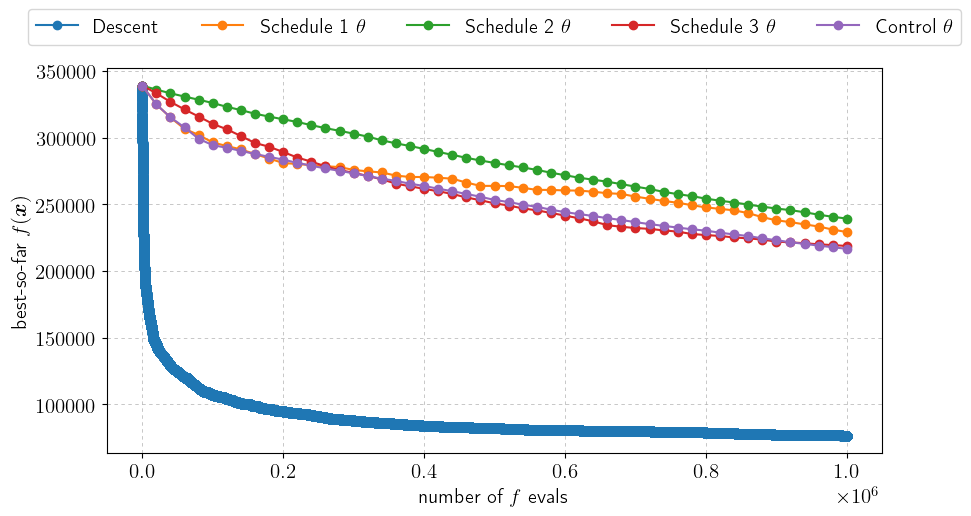

In [69]:
import matplotlib.pyplot as plt


def plot_trajectories(results_list):
    fig, ax = plt.subplots(figsize=(10, 5))

    for res, label in results_list:
        # Split into x and y lists
        x, y = zip(*res["history"])
        # Plot the data
        ax.plot(x, y, marker="o", label=label)

    # Place legend above the plot (centered)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),  # adjust vertical spacing
        ncol=len(results_list),  # number of columns in legend
        frameon=True,
    )

    ax.set_xlabel("number of $f$ evals")
    ax.set_ylabel(r"best-so-far $f(\bm{x})$")
    # ax.set_title("Plot of (x, y) pairs")

    # plt.tight_layout()
    plt.show()


results_list = [
    (res_descent, "Descent"),
    (res_theta_schedule, r"Schedule 1 $\theta$"),
    (res_theta_schedule_2, r"Schedule 2 $\theta$"),
    (res_theta_schedule_3, r"Schedule 3 $\theta$"),
    (res_theta_control, r"Control $\theta$"),
]
plot_trajectories(results_list)


### Control on another instance

In [70]:
cvrp_other = nn.get_cvrp_instance("X-n143-k7.xml")

print("Running theta control")

res_theta_control_other = ea.one_plus_lambda_ea_with_theta_control(
    cvrp_other,
    theta_schedule_window=[100.0, 100.0, 50.0, 50.0, 20.0],
    window=constants.ea_window_size,
    theta_control_fun=predict_theta,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running descent")


res_descent_other = ea.descent(
    cvrp=cvrp_other,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    mutation=constants.ea_mutation_operator,
    seed=constants.random_seed,
)
print(res_descent_other["best_fitness"])

print("Running theta fixed")

res_theta_schedule_other = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp_other,
    theta_schedule=np.linspace(100.0, 1.0, constants.ea_generations_number), #[10.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 2")

res_theta_schedule_other_2 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp_other,
    theta_schedule=[1.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 3")

res_theta_schedule_other_3 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp_other,
    theta_schedule=[10.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)


Running theta fixed 2
[init] fitness=79288.000000
[gen 1] theta=1 fitness=76539.000000 ↑ evals=20001/1000001
[gen 2] theta=1 fitness=73251.000000 ↑ evals=40001/1000001
[gen 3] theta=1 fitness=70304.000000 ↑ evals=60001/1000001
[gen 4] theta=1 fitness=67695.000000 ↑ evals=80001/1000001
[gen 5] theta=1 fitness=65310.000000 ↑ evals=100001/1000001
[gen 6] theta=1 fitness=62757.000000 ↑ evals=120001/1000001
[gen 7] theta=1 fitness=60609.000000 ↑ evals=140001/1000001
[gen 8] theta=1 fitness=58513.000000 ↑ evals=160001/1000001
[gen 9] theta=1 fitness=56845.000000 ↑ evals=180001/1000001
[gen 10] theta=1 fitness=55290.000000 ↑ evals=200001/1000001
[gen 11] theta=1 fitness=53758.000000 ↑ evals=220001/1000001
[gen 12] theta=1 fitness=52453.000000 ↑ evals=240001/1000001
[gen 13] theta=1 fitness=51145.000000 ↑ evals=260001/1000001
[gen 14] theta=1 fitness=49654.000000 ↑ evals=280001/1000001
[gen 15] theta=1 fitness=47939.000000 ↑ evals=300001/1000001
[gen 16] theta=1 fitness=46484.000000 ↑ evals=32

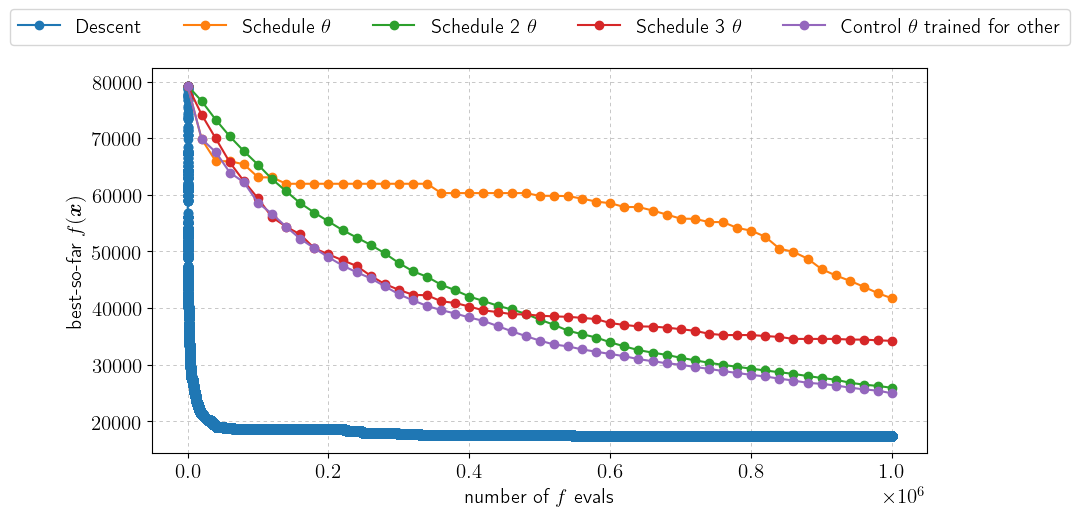

In [71]:
results_list = [
    (res_descent_other, "Descent"),
    (res_theta_schedule_other, r"Schedule $\theta$"),
    (res_theta_schedule_other_2, r"Schedule 2 $\theta$"),
    (res_theta_schedule_other_3, r"Schedule 3 $\theta$"),
    (res_theta_control_other, r"Control $\theta$ trained for other"),
]
plot_trajectories(results_list)

In [72]:
cvrp_other_other = nn.get_cvrp_instance("X-n1001-k43.xml")

print("Running theta control")

res_theta_control_other_other= ea.one_plus_lambda_ea_with_theta_control(
    cvrp_other_other,
    theta_schedule_window=[100.0, 100.0, 50.0, 50.0, 20.0],
    window=constants.ea_window_size,
    theta_control_fun=predict_theta,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running descent")


res_descent_other_other = ea.descent(
    cvrp=cvrp_other_other,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    mutation=constants.ea_mutation_operator,
    seed=constants.random_seed,
)
print(res_descent_other["best_fitness"])

print("Running theta fixed")

res_theta_schedule_other_other = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp_other_other,
    theta_schedule=np.linspace(100.0, 1.0, constants.ea_generations_number), #[10.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 2")

res_theta_schedule_other_other_2 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp_other_other,
    theta_schedule=[1.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 3")

res_theta_schedule_other_other_3 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp_other_other,
    theta_schedule=[10.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)


Running theta control
[init] fitness=528106.000000
[gen 1] theta=100 fitness=513458.000000 ↑ evals=20001/1000001
[gen 2] theta=100 fitness=501002.000000 ↑ evals=40001/1000001
[gen 3] theta=50 fitness=493043.000000 ↑ evals=60001/1000001
[gen 4] theta=50 fitness=486045.000000 ↑ evals=80001/1000001
[gen 5] theta=20 fitness=479346.000000 ↑ evals=100001/1000001
[gen 6] theta=1 fitness=477097.000000 ↑ evals=120001/1000001
[gen 7] theta=1 fitness=474540.000000 ↑ evals=140001/1000001
[gen 8] theta=1 fitness=472260.000000 ↑ evals=160001/1000001
[gen 9] theta=1 fitness=469951.000000 ↑ evals=180001/1000001
[gen 10] theta=1 fitness=467540.000000 ↑ evals=200001/1000001
[gen 11] theta=3.48 fitness=464232.000000 ↑ evals=220001/1000001
[gen 12] theta=1.11 fitness=461640.000000 ↑ evals=240001/1000001
[gen 13] theta=1.98 fitness=458822.000000 ↑ evals=260001/1000001
[gen 14] theta=1 fitness=456053.000000 ↑ evals=280001/1000001
[gen 15] theta=2.26 fitness=453526.000000 ↑ evals=300001/1000001
[gen 16] thet

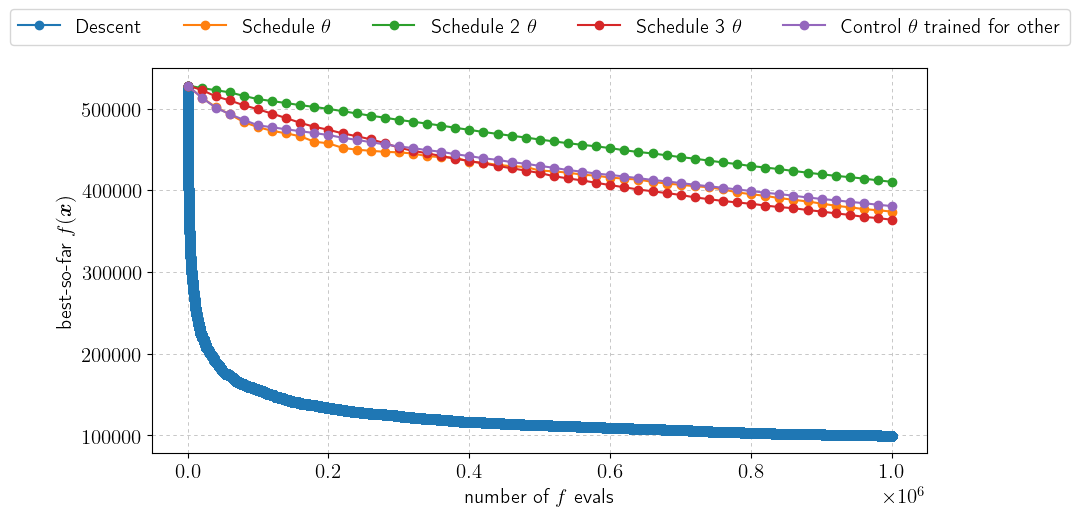

In [73]:
results_list = [
    (res_descent_other_other, "Descent"),
    (res_theta_schedule_other_other, r"Schedule $\theta$"),
    (res_theta_schedule_other_other_2, r"Schedule 2 $\theta$"),
    (res_theta_schedule_other_other_3, r"Schedule 3 $\theta$"),
    (res_theta_control_other_other, r"Control $\theta$ trained for other"),
]
plot_trajectories(results_list)

### Local Optimization

In [78]:

# sol = res_descent["best_perm"]

# print(cvrp.dynamic_programming_fitness(sol))
res = ea.descent(cvrp, max_evals=10**4, mutation=ea.mutate_shift_2opt_fast_fast, verbose=False, seed=random_seed)
print(res["best_fitness"])

166521.0


In [79]:
res_theta_control = ea.one_plus_lambda_ea_with_theta_control(
    cvrp,
    theta_schedule_window=[100.0, 100.0, 50.0, 50.0, 20.0],
    window=constants.ea_window_size,
    theta_control_fun=predict_theta,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_ - 10**4,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
    init_perm=res["best_perm"]
)


[init] fitness=166521.000000
[gen 1] theta=100 fitness=166521.000000 · evals=20001/990001
[gen 2] theta=100 fitness=166521.000000 · evals=40001/990001
[gen 3] theta=50 fitness=166521.000000 · evals=60001/990001
[gen 4] theta=50 fitness=166521.000000 · evals=80001/990001
[gen 5] theta=20 fitness=166521.000000 · evals=100001/990001
[gen 6] theta=1 fitness=165596.000000 ↑ evals=120001/990001
[gen 7] theta=1 fitness=164614.000000 ↑ evals=140001/990001
[gen 8] theta=1 fitness=163730.000000 ↑ evals=160001/990001
[gen 9] theta=1 fitness=163046.000000 ↑ evals=180001/990001
[gen 10] theta=1 fitness=162294.000000 ↑ evals=200001/990001
[gen 11] theta=3.47 fitness=161525.000000 ↑ evals=220001/990001
[gen 12] theta=1.11 fitness=160856.000000 ↑ evals=240001/990001
[gen 13] theta=1.98 fitness=160329.000000 ↑ evals=260001/990001
[gen 14] theta=1 fitness=159677.000000 ↑ evals=280001/990001
[gen 15] theta=2.26 fitness=159139.000000 ↑ evals=300001/990001
[gen 16] theta=1.02 fitness=158494.000000 ↑ evals=